## Get hotel parameters 

In [142]:
import urllib.request, json
import requests
import vertica_python as vp
import numpy as np
import pandas as pd
import time
from sklearn.cluster import KMeans
import matplotlib.pyplot
from matplotlib import pylab as plt
from __future__ import generators

In [4]:
def ResultIter(cursor, arraysize=1000):
    'An iterator that uses fetchmany to keep memory usage down'
    while True:
        results = cursor.fetchmany(arraysize)
        if not results:
            break
        for result in results:
            yield result

In [5]:
basic_conn_info = {'host': 'stat-vertica-db.ostrovok.ru',
            'port': 5433,
            'user': 'readonly_user',
            'password': 'readonly_user_vertica_prod',
            'database': 'verticaprod',
            # 10 minutes timeout on queries
            'read_timeout': 600,
            # default throw error on invalid UTF-8 results
            'unicode_error': 'strict',
            # SSL is disabled by default
            'ssl': False}

In [10]:
storage=[]
with vp.connect(**basic_conn_info) as connection:
        cur = connection.cursor()
        cur.execute("with c as ( select currency_to, actual_date, avg_rate as rate FROM analytics.currency_history ) ,t as ( select otahotel_id, round(coalesce((price) / c.rate::float * cc.rate::float/length_of_stay, 1),3) as price_converted from weblogs2.hc_displays hc left join c on c.actual_date = hc.datetime::date and upper(hc.currency) = c.currency_to left join c cc on cc.actual_date = hc.datetime::date and cc.currency_to = 'RUB' where datetime>=now()::date - '6 month'::interval and length_of_stay>0 ), hotel_prices as ( select otahotel_id, avg(price_converted) as price from t group by 1 ), content_scores as ( SELECT distinct otahotel_id, first_value(hotel_gallery_score) OVER(PARTITION BY otahotel_id ORDER BY created_at desc) AS last_gallery_score, first_value(hotel_gallery_filled) OVER(PARTITION BY otahotel_id ORDER BY created_at desc) AS last_gallery_filled, first_value(amenities_score) OVER(PARTITION BY otahotel_id ORDER BY created_at desc) AS last_amenities_score, first_value(hotel_gallery_photos_good_size) OVER(PARTITION BY otahotel_id ORDER BY created_at desc) AS last_gallery_photos_good_size FROM content.content_score ) select distinct sn.otahotel_id, country_en, city_en, last_value (sn.star_rating) over (PARTITION BY sn.otahotel_id ORDER BY sn.updated_at asc) as star_rating, last_value (sn.kind) over (PARTITION BY sn.otahotel_id ORDER BY sn.updated_at asc) as kind, last_gallery_score, last_gallery_filled, last_amenities_score, last_gallery_photos_good_size, price from content.content_snapshot sn left join content_scores sc on sn.otahotel_id = sc.otahotel_id left join public.otahotel o on o.id = sn.otahotel_id left join hotel_prices p on p.otahotel_id = sn.otahotel_id where sn.kind is not null and sn.star_rating is not null and price is not null ")
        for row in ResultIter(cur,arraysize=10000):
            storage.append(row)

In [32]:
df = pd.DataFrame(storage, columns=['otahotel_id', 'country', 'city', 'star_rating', 'kind', 'gallery_score', 'gallery_filled', 'amenities_score', 'gallery_photos_good_size', 'price'] )
df

,otahotel_id,country,city,star_rating,kind,gallery_score,gallery_filled,amenities_score,gallery_photos_good_size,price
0,008_bond_villa,South Africa,Cape Town,50,Villas_and_Bungalows,81,81,100,81,87471.875000
1,018_in,Serbia,Nis,30,Hotel,48,96,100,0,3006.934833
2,04village_namba,Japan,Osaka,10,Hostel,87,89,100,85,5321.002500
3,06_central_hostel_buenos_aires_2,Argentina,Buenos Aires,20,Hostel,62,78,100,47,938.908125
4,08028_apartments,Spain,Barcelona,30,Apartment,100,100,100,100,12889.798668
5,0898_express_hotel,China,Haikou,20,Hotel,85,88,100,82,1587.000000
6,0liva_hotel,China,Foshan,40,Hotel,88,88,100,88,1612.758250
7,1000_home_apartments,Hungary,Heviz,40,Apartment,80,92,100,69,5140.486463
8,1000_islands_harbor_hotel,United States of America,Clayton,40,Hotel,100,100,100,100,1.000000
9,1000_miles,Malaysia,Kuala Lumpur,25,Hotel,85,100,100,70,1457.243290


In [196]:
df.to_csv('content_data', index = False)

In [203]:
storage=[]
with vp.connect(**basic_conn_info) as connection:
        cur = connection.cursor()
        cur.execute("select otahotel_id, count(id) from weblogs2.hc_displays where datetime>=now()::date - '6 month'::interval and length_of_stay>0 and type = 'serp' and region_id in (with t as ( select region_id, count(id) as cnt from weblogs2.hc_displays group by 1 ) select region_id from t order by cnt desc limit 100) group by 1")
        for row in ResultIter(cur,arraysize=10000):
            storage.append(row)

In [204]:
shows = pd.DataFrame(storage, columns=['otahotel_id', 'shows'] )
shows

,otahotel_id,shows
0,gostinitsa_lazurnyi_briz,7178
1,forsthaus_wornbrunn_gmbh_restaurant__hotel,24
2,lou_mire_inh_27910,12
3,grand_hotel_villa_medici__a_sina_hotel,481
4,wallada_place,30
5,etazhi_na_8_marta_188_apartments,155
6,lada_3,862
7,valeo_hotel,141
8,rahab_hotel,2198
9,apartment_rental_services,646


In [205]:
shows.to_csv('content_shows', index = False)

In [206]:
shows = pd.read_csv('content_shows', encoding = 'koi8_r', index_col= False)
shows

,otahotel_id,shows
0,gostinitsa_lazurnyi_briz,7178
1,forsthaus_wornbrunn_gmbh_restaurant__hotel,24
2,lou_mire_inh_27910,12
3,grand_hotel_villa_medici__a_sina_hotel,481
4,wallada_place,30
5,etazhi_na_8_marta_188_apartments,155
6,lada_3,862
7,valeo_hotel,141
8,rahab_hotel,2198
9,apartment_rental_services,646


In [197]:
df = pd.read_csv('content_data', encoding = 'koi8_r', index_col= False)

In [198]:
df

,otahotel_id,country,city,star_rating,kind,gallery_score,gallery_filled,amenities_score,gallery_photos_good_size,price
0,008_bond_villa,South Africa,Cape Town,50,Villas_and_Bungalows,81,81,100,81,87471.875000
1,018_in,Serbia,Nis,30,Hotel,48,96,100,0,3006.934833
2,04village_namba,Japan,Osaka,10,Hostel,87,89,100,85,5321.002500
3,06_central_hostel_buenos_aires_2,Argentina,Buenos Aires,20,Hostel,62,78,100,47,938.908125
4,08028_apartments,Spain,Barcelona,30,Apartment,100,100,100,100,12889.798668
5,0898_express_hotel,China,Haikou,20,Hotel,85,88,100,82,1587.000000
6,0liva_hotel,China,Foshan,40,Hotel,88,88,100,88,1612.758250
7,1000_home_apartments,Hungary,Heviz,40,Apartment,80,92,100,69,5140.486463
8,1000_islands_harbor_hotel,United States of America,Clayton,40,Hotel,100,100,100,100,1.000000
9,1000_miles,Malaysia,Kuala Lumpur,25,Hotel,85,100,100,70,1457.243290


In [92]:
df2 = pd.DataFrame(df.groupby(['country', 'city'])['price'].mean()).rename(columns = {'price':'region_price'}).reset_index()

In [93]:
df2.head()

,country,city,region_price
0,Abkhazia,Candriph,2032.431476
1,Abkhazia,Gagra,5045.630652
2,Abkhazia,Gudauta,1573.012423
3,Abkhazia,Novii Afon,2925.189801
4,Abkhazia,Sukhum,3254.335295


In [209]:
df_main = pd.merge(df, df2, how='left', on=['country','city'])

In [210]:
df3 = pd.DataFrame(df.groupby(['country', 'city', 'star_rating', 'kind'])['price'].mean()).rename(columns = {'price':'group_price'}).reset_index()

In [211]:
df_main = pd.merge(df_main, df3, how='left', on=['country','city', 'star_rating', 'kind'])

In [212]:
df_main = pd.merge(df_main, shows, how = 'inner', on=['otahotel_id'])

In [213]:
df_main

,otahotel_id,country,city,star_rating,kind,gallery_score,gallery_filled,amenities_score,gallery_photos_good_size,price,region_price,group_price,shows
0,08028_apartments,Spain,Barcelona,30,Apartment,100,100,100,100,12889.798668,11715.547051,10536.250632,1177
1,100_sunset_2_hotel,Indonesia,Kuta,30,Hotel,100,100,100,100,1995.635500,2410.931923,1846.530476,28
2,100_sunset_boutique_hotel,Indonesia,Kuta,30,Boutique_and_Design,100,100,100,100,1847.271883,2410.931923,1562.146856,12
3,100_sunset_boutique_hotel,Indonesia,Kuta,40,Boutique_and_Design,100,100,100,100,1847.271883,2410.931923,3976.569399,12
4,101_holiday_suite,Thailand,Bangkok,0,Apartment,95,96,100,95,2593.229094,2775.429908,3175.023838,41
5,101_star,Vietnam,Nha Trang,20,Hotel,100,100,100,100,2283.097316,3524.596787,1591.024708,223
6,104_rooms_hostel,Russia,Voronezh,20,Hostel,100,100,100,100,900.409434,2855.810634,900.409434,1893
7,108_minut_khostel_,Russia,Moscow,30,Hostel,100,100,100,100,1691.434091,3951.707319,1961.140737,14455
8,108beds,Thailand,Si Racha,20,Hostel,85,85,100,85,923.196659,3099.557114,923.196659,217
9,10_karakoy_a_morgans_original,Turkey,Istanbul,40,Hotel,100,100,100,100,3009.624254,3827.031496,5410.670790,1424


In [215]:
df_main['price_koeff'] = df_main['group_price']/df_main['region_price']

In [252]:
g = df_main.groupby(['country', 'city'])

In [270]:
l = []
for key, region_df in g:
    n_samples = 1500
    region_df = region_df.dropna()
    X = region_df[["price_koeff"]]
    if len(X)<6:
        continue
    y_pred = KMeans(n_clusters= 5, random_state=100).fit_predict(np.reshape(X, len(X), 1))
    region_df['cluster'] = y_pred
    l.append(region_df)
final_df = pd.concat(l)

In [303]:
final_df = final_df.groupby(['country', 'city']).apply(lambda x: x.sort_values(['shows'], ascending = False).reset_index(drop=True))

In [167]:
X = df_main[df_main.city =='Moscow'][["price_koeff"]]

Int64Index([    38,    250,    251,    620,    909,   1141,   1199,   3013,
              3883,   4916,
            ...
            216732, 216784, 216803, 217135, 217657, 217721, 221245, 221858,
            222075, 222077],
           dtype='int64', length=699)

In [187]:
n_samples = 1500

y_pred = KMeans(n_clusters=6, random_state=100).fit_predict(X)

In [188]:
plt.figure(figsize=[15, 12])
matplotlib.pyplot.scatter(X.index, X,c=y_pred)

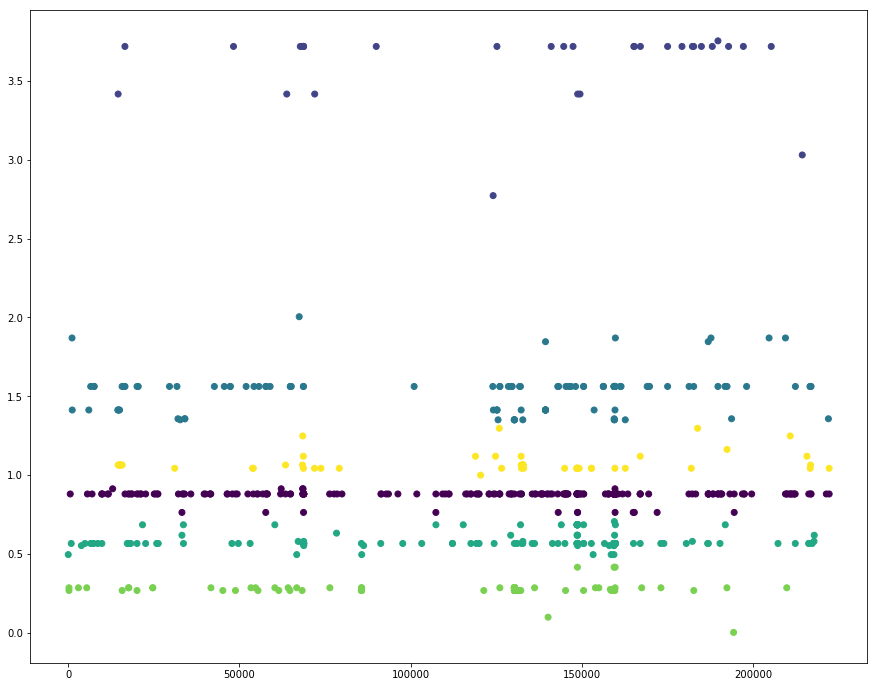

In [189]:
plt.show()